In [2]:
from copy import deepcopy

import pandas as pd
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

torch.set_default_dtype(torch.float64)

# plt.style.use(['dark_background', 'bmh'])
plt.style.use(['seaborn-v0_8-whitegrid', 'bmh'])
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rc('axes', facecolor='w')
plt.rc('figure', facecolor='w')
plt.rc('figure', figsize= (6, 3), dpi=150)

import warnings
warnings.filterwarnings('ignore')

import os
dir_sv_result = './result_exp'
os.makedirs(dir_sv_result, exist_ok = True)

dir_trainset = './trainset'
os.makedirs(dir_trainset, exist_ok = True)

c:\Users\user\anaconda3\envs\CPKL_GPytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Examples for sample size**
- For 1d-Dataset: `torch.Size([20]) torch.Size([20]) torch.Size([100]) torch.Size([100])`  
- For 2d-dataset: `torch.Size([20, 2]) torch.Size([20]) torch.Size([100, 2]) torch.Size([100])`  
- For nd-dataset: `torch.Size([20, n]) torch.Size([20]) torch.Size([100, n]) torch.Size([100])`

### **Define functions for case studies**

In [3]:
from gpytorch.kernels import RBFKernel, LinearKernel, RQKernel, MaternKernel, CosineKernel, PeriodicKernel

def define_base_kernels(train_x, traindata_info):

    # Set active dimensions
    action_dims = torch.tensor([i for i in range(0, train_x.dim())])
    # traindata_info['min_dist_x'], traindata_info['max_dist_y'], traindata_info['min_dist_y'], traindata_info['max_dist_y']

    lengthscale_prior = gpytorch.priors.NormalPrior(
        traindata_info['med_dist_x'], traindata_info['max_dist_x'] - traindata_info['min_dist_x'])
    variance_prior = gpytorch.priors.NormalPrior(
        traindata_info['med_dist_y'], traindata_info['max_dist_y'] - traindata_info['min_dist_y'])
    periodlength_prior = gpytorch.priors.NormalPrior(
        traindata_info['med_dist_x'], traindata_info['max_dist_x'] - traindata_info['min_dist_x'])

    period_length_constraint = gpytorch.constraints.Interval(
        0.5*traindata_info['min_dist_x'], traindata_info['max_dist_x']*1.5)

    for i in range(0, train_x.dim()):
        if i == 0:
            lin_ken = LinearKernel(active_dims=i, variance_prior=variance_prior, variance_constraint=gpytorch.constraints.Interval(
                0.5*traindata_info['min_dist_y'], traindata_info['max_dist_y']*1.5))

            # Samller values of period_length means higher frequency in signals
            cos_ken = CosineKernel(active_dims=i, period_length_prior=periodlength_prior, period_length_constraint=gpytorch.constraints.Interval(
                0.5 * traindata_info['min_dist_x'], traindata_info['max_dist_x'] * 1.5))
            cos_ken1 = CosineKernel(active_dims=i, period_length_prior=periodlength_prior,
                                    period_length_constraint=gpytorch.constraints.LessThan(0.5*traindata_info['min_dist_x']))

        else:
            lin_ken *= lin_ken
            cos_ken *= cos_ken
            cos_ken1 *= cos_ken1

    # define the kernels
    base_kernels = {
        'rbf': lambda: RBFKernel(active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior),
        'lin': lambda: lin_ken,
        # 'cos': lambda: cos_ken,
        # 'cos1': lambda: cos_ken1,
        # 'per': lambda: PeriodicKernel(active_dims=action_dims, ard_num_dims=len(action_dims),
        #                             period_length_prior=periodlength_prior, lengthscale_prior=lengthscale_prior,
        #                             period_length_constraint = period_length_constraint),
        'rq': lambda: RQKernel(active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior,),
        'mat12': lambda: MaternKernel(nu=0.5, active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior),
        'mat32': lambda: MaternKernel(nu=1.5, active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior),
        'mat52': lambda: MaternKernel(nu=2.5, active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior),
    }

    # base_likelihood = lambda: gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())

    def base_likelihood(): return gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.GreaterThan(1e-3))

    # Assume: likelihood noise constraint was defined so that 1e-4 is within range.
    likelihood0 = base_likelihood()
    if 0:
        # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
        likelihood0.noise = 1e-4
        # Mark that we don't want to train the noise.
        likelihood0.noise_covar.raw_noise.requires_grad_(False)

    return base_kernels, likelihood0

In [4]:
from Util_CPKL import *

def run_experimental_data_for_CPKL(trainset, testset, rand_seed0, plot_result_on = False):
    # Run CPKL
    multi_restart_option = {}
    multi_restart_option['sampling'] = 'random'
    multi_restart_option['n_eval'] = 20
    
    # Assign input and output from tuples
    train_y_all, train_x_all = trainset
    test_y_all, test_x_all  = testset

    train_x, test_x = train_x_all.float(), test_x_all.float()
    train_y, test_y =  train_y_all.float(), test_y_all.float()
    
    # get information trainint set for initializing hyper-parameters
    traindata_info = initialize_hyperparameters(train_x, train_y)
    multi_restart_option['traindata_info'] = traindata_info
    
    # Define base_kernels
    base_kernels, likelihood0 = define_base_kernels(train_x, traindata_info)

    best_model, best_models, best_metrics, best_index = RUN_CPKL(train_x, train_y, likelihood0, base_kernels,
                                                    test_x=test_x, test_y=test_y, multi_restart_option=multi_restart_option,
                                                    fix_value_learned=True, max_depth=15, rand_seed0=rand_seed0,
                                                    training_iter=100, standardize=True, tolerance=1e-3, plot_intermediate_on=False)
    
    best_metrics = torch.tensor(best_metrics)
    
    mae, mse = plot_result(best_model, test_x, test_y, plot_on = plot_result_on)
    print(f"MAE : {mae:.3f} // MSE : {mse:.3f}")
    print("%%%%%%%" * 3)

    return best_model, best_models, best_metrics, best_index


def plot_metrics(mae, mse, best_index):
    fig, axs = plt.subplots(1, 2, figsize = (5, 2), dpi = 200)
    axs[0].plot(mae)
    axs[0].plot(best_index, mae[best_index], 'ro')
    axs[0].set_title('mae')
    axs[1].plot(mse)
    axs[1].plot(best_index, mse[best_index], 'ro')
    axs[1].yaxis.tick_right()
    axs[1].set_title('mse')
    plt.show()

### **1. Construct GPModels using whole LF-data**

List for Loading Case: [0]
# Case : 0


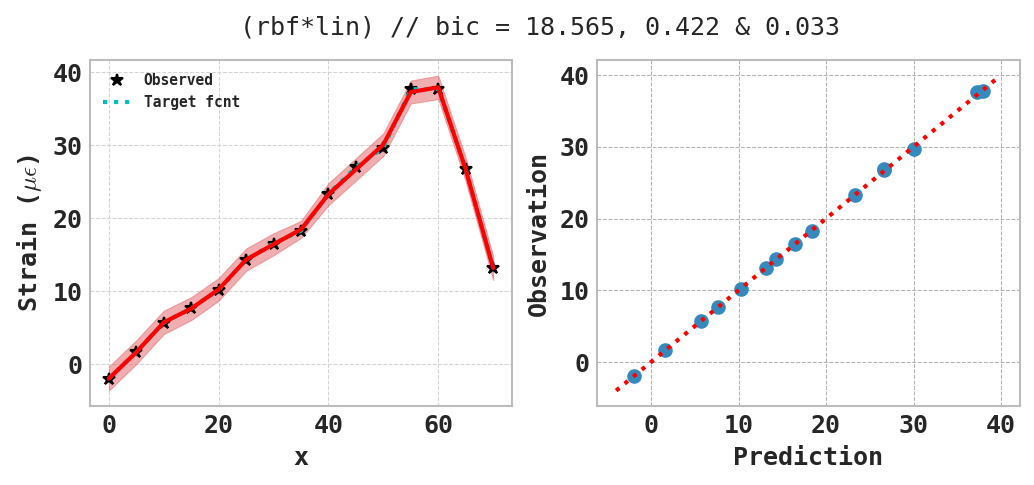

MAE : 0.422 // MSE : 0.033
%%%%%%%%%%%%%%%%%%%%%


In [5]:
import pickle

data_type = 'LF'
fn_lists = [
    f'simplebeam_strain_{data_type}0.csv',
    f'simplebeam_strain_{data_type}1.csv',
    f'simplebeam_strain_{data_type}2.csv',
    f'slab1_strain_{data_type}.csv',
    f'slab2_strain_{data_type}.csv',
    f'Yongsu_strain_{data_type}.csv',
]

rand_seed0, plot_on = 1234, False

for fn in fn_lists:
    fn_str = fn.split('_')

    # Import HF-data
    df = pd.read_csv('./Data/' + fn)
    if df.shape[1] == 2: # 1d
        i_loads, input_dim = np.arange(df.shape[1] - 1), 1
    else:
        i_loads, input_dim = np.arange(df.shape[1] - 2), 2

    print(f"List for Loading Case: {i_loads}")

    for i_load in i_loads:
        # Set testdata
        if input_dim == 1: # 1D
            trainset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim].values))
            testset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim].values))
        else: # 2D
            testset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim:].values))
            trainset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim:].values))

        # Fit GPModel using subsets of HF-data
        print(f"# Case : {i_load}") # df_tmp.shape[0]
        
        plot_on = True
        best_model, best_models, best_metrics, best_index = run_experimental_data_for_CPKL(deepcopy(trainset), deepcopy(testset), rand_seed0, plot_on)
        mae, mse = best_metrics[best_index, :]
        
        # Save best and worst GPModels
        fn_sv = f"Best_{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.pth"
        torch.save(best_model.state_dict(), f'{dir_sv_result}/{fn_sv}')

### **2. Construct GPModels using only HF-data (i.e. subsets)**

In [6]:
import pickle

data_type = 'HF'
fn_lists = [
    f'simplebeam_strain_{data_type}0.csv',
    f'simplebeam_strain_{data_type}1.csv',
    f'simplebeam_strain_{data_type}2.csv',
    f'slab1_strain_{data_type}.csv',
    f'slab2_strain_{data_type}.csv',
    f'Yongsu_strain_{data_type}.csv',
]

ratio_min, ratio_max = 0.3, 0.7
i_sample_min, i_sample_max = 6, 10
# ratio_min, ratio_max = 0.4, 0.5
rand_seed0, plot_on = 1234, False
n_rep = 10

for fn in fn_lists:
    fn_str = fn.split('_')

    # Import HF-data
    df = pd.read_csv('./Data/' + fn)
    if df.shape[1] == 2: # 1d
        i_loads, input_dim = np.arange(df.shape[1] - 1), 1
    else:
        i_loads, input_dim = np.arange(df.shape[1] - 2), 2

    print(f"List for Loading Case: {i_loads}")

    for i_load in i_loads:
        # Set testdata
        if input_dim == 1:
            testset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim].values)) # 1D
        else:
            testset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim:].values)) # 1D

        # Loop for generating trainingset via stratified sampling
        trainingset_all = []
        train_set_all_mae, train_set_all_mse = np.full((n_rep,1),np.nan), np.full((n_rep,1),np.nan)
        if input_dim == 1:
            i_samples = np.unique(np.linspace(df.shape[0] * ratio_min, df.shape[0] * ratio_max, 5, dtype = int))
        else:
            i_samples = np.unique(np.arange(i_sample_min, i_sample_max + 1, dtype = int))

        print(f"List for # Samples: {i_samples}")

        for ind_sample in i_samples: # increase trainingset ratio
            if input_dim == 1:
                # Get minimal and maximal inputs
                xmin_, xmax_ = testset[-1].min(), testset[-1].max()
                
                # Generate stratified intervals (cut_interval)
                cut_interval = np.linspace(xmin_, xmax_, ind_sample + 1)
                cut_interval[0], cut_interval[-1] = - np.inf, np.inf

                df['cut'] = pd.cut(df['x'], bins = cut_interval, labels = [i for i in range(cut_interval.shape[0] - 1)])
                tmp = df.groupby('cut', group_keys=False)
                
                train_set_mae, train_set_mse = [], []
                train_set, model_list = [], []

                for i_rep in range(n_rep): # repeat random sampling based on stratified intervals
                    df_tmp = tmp.apply(lambda x: x.sample(1, replace=True, random_state = rand_seed0 * i_rep))
                    df_tmp.drop('cut', axis=1, inplace=True)
                    
                    trainset = (torch.tensor(df_tmp.iloc[:, i_load].values), torch.tensor(df_tmp.iloc[:, -input_dim].values))

                    # Fit GPModel using subsets of HF-data
                    print(f"[{i_rep + 1}/{n_rep}] # sample : {ind_sample} // # Case : {i_load}") # df_tmp.shape[0]
                    best_model, best_models, best_metrics, best_index = run_experimental_data_for_CPKL(deepcopy(trainset), deepcopy(testset), rand_seed0, plot_on)
                    mae, mse = best_metrics[best_index, :]

                    # Append GPModel
                    model_list.append(best_model)
                    train_set_mae.append(mae.item())
                    train_set_mse.append(mse.item())
                    train_set.append(df_tmp)

            else: # 2D
                    np.random.seed(rand_seed0) # for reproducibility
                    if fn_str[0] == 'slab1': # LF-data at x = 300 was not measured
                        df_tmp = df.iloc[3:, :]
                        
                    else:
                        df_tmp = df.iloc[:, :]

                    train_set_mae, train_set_mse = [], []
                    train_set, model_list = [], []

                    for i_rep in range(n_rep): # repeat random sampling based on stratified intervals
                        ind_train = np.random.choice(df_tmp.shape[0], ind_sample, replace=False)
                        trainset = (torch.tensor(df_tmp.iloc[ind_train, i_load].values), torch.tensor(df_tmp.iloc[ind_train, -input_dim:].values))
                        
                        plot_on = True
                        
                        # Fit GPModel using subsets of HF-data
                        print(f"[{i_rep + 1}/{n_rep}] # sample : {ind_sample} // # Case : {i_load}") # df_tmp.shape[0]
                        best_model, best_models, best_metrics, best_index = run_experimental_data_for_CPKL(deepcopy(trainset), deepcopy(testset), rand_seed0, plot_on)
                        mae, mse = best_metrics[best_index, :]

                        # Append GPModel
                        model_list.append(best_model)
                        train_set_mae.append(mae.item())
                        train_set_mse.append(mse.item())
                        train_set.append(df_tmp.iloc[ind_train, :])

            # Find indices of best and worst model
            train_set_mae = np.array(train_set_mae).reshape(-1, 1)
            train_set_mse = np.array(train_set_mse).reshape(-1, 1)

            ind_best = np.array(train_set_mae).argmin()
            ind_worst = np.array(train_set_mae).argmax()

            # Save best and worst GPModels
            fn_sv = f"Best_{fn_str[0]}_{fn_str[-1].split('.')[0]}_N{ind_sample}_Case{i_load}.pth"
            torch.save(model_list[ind_best].state_dict(), f'{dir_sv_result}/{fn_sv}')

            fn_sv = f"Worst_{fn_str[0]}_{fn_str[-1].split('.')[0]}_N{ind_sample}_Case{i_load}.pth"
            torch.save(model_list[ind_worst].state_dict(), f'{dir_sv_result}/{fn_sv}')

            # Append training data & metrics
            trainingset_all.append(train_set)
            if np.isnan(train_set_all_mae).all():
                train_set_all_mae, train_set_all_mse = train_set_mae, train_set_mse
            else:
                train_set_all_mae = np.concatenate([train_set_all_mae, train_set_mae], axis = 1)
                train_set_all_mse = np.concatenate([train_set_all_mse, train_set_mse], axis = 1)

    df_mae = pd.DataFrame(train_set_all_mae)
    df_mae.columns = i_samples
    df_mse = pd.DataFrame(train_set_all_mse)
    df_mse.columns = i_samples

    df_mae.to_csv(dir_trainset + '/' + f"MAE_{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.csv")
    df_mse.to_csv(dir_trainset + '/' + f"MSE_{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.csv")

    # Save trainingset
    fn_train_sv = f"{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.pkl"
    values_saved = {
        'trainingset_all': trainingset_all, 'testset': testset,
        }
    with open(dir_trainset + '/' + fn_train_sv, 'wb') as file:
        pickle.dump(values_saved, file)

List for Loading Case: [0]
List for # Samples: [ 4  6  7  9 10]
[1/10] # sample : 4 // # Case : 0
MAE : 18.187 // MSE : 24.993
%%%%%%%%%%%%%%%%%%%%%
[2/10] # sample : 4 // # Case : 0
MAE : 12.699 // MSE : 48.604
%%%%%%%%%%%%%%%%%%%%%
[3/10] # sample : 4 // # Case : 0
MAE : 12.713 // MSE : 48.884
%%%%%%%%%%%%%%%%%%%%%
[4/10] # sample : 4 // # Case : 0
MAE : 16.728 // MSE : 20.597
%%%%%%%%%%%%%%%%%%%%%
[5/10] # sample : 4 // # Case : 0
MAE : 18.191 // MSE : 25.010
%%%%%%%%%%%%%%%%%%%%%
[6/10] # sample : 4 // # Case : 0
MAE : 13.297 // MSE : 14.872
%%%%%%%%%%%%%%%%%%%%%
[7/10] # sample : 4 // # Case : 0
MAE : 18.188 // MSE : 24.999
%%%%%%%%%%%%%%%%%%%%%
[8/10] # sample : 4 // # Case : 0
MAE : 13.302 // MSE : 14.878
%%%%%%%%%%%%%%%%%%%%%
[9/10] # sample : 4 // # Case : 0
MAE : 11.506 // MSE : 21.844
%%%%%%%%%%%%%%%%%%%%%
[10/10] # sample : 4 // # Case : 0
MAE : 11.498 // MSE : 21.813
%%%%%%%%%%%%%%%%%%%%%
[1/10] # sample : 6 // # Case : 0
MAE : 16.971 // MSE : 21.235
%%%%%%%%%%%%%%%%%%%%%


In [ ]:
# with open(dir_trainset + '/' + fn_train_list[0], 'rb') as f:
#     dict = pickle.load(f)

# trainingset = dict['trainingset']
# testset = dict['testset']
# testset